In [1]:
import os
from pathlib import Path
from typing import List, Dict, TypedDict

from dotenv import load_dotenv
from qdrant_client import QdrantClient
from openai import OpenAI

from langchain.schema import Document
from langchain_core.retrievers import BaseRetriever
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field

# Load environment variables from .env
load_dotenv()
env_path = Path('.') / '.env'
if env_path.exists():
    with open(env_path) as f:
        for line in f:
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ.setdefault(key, value)

QDRANT_URL = os.environ["QDRANT_URL"]
QDRANT_API_KEY = os.environ["QDRANT_API_KEY"]
COLLECTION_NAME = os.environ["QDRANT_COLLECTION_NAME"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

# Initialize clients
qdrant = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)
openai_client = OpenAI(api_key=OPENAI_API_KEY)


In [2]:
# Helper: embed the query using OpenAI
def get_query_embedding(text: str) -> List[float]:
    response = openai_client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return response.data[0].embedding

# Retrieve documents via qdrant.search and wrap them in Document objects
def retrieve_chunks(query: str, k: int = 5, threshold: float = 0.35) -> List[Document]:
    query_vector = get_query_embedding(query)
    results = qdrant.search(
        collection_name=COLLECTION_NAME,
        query_vector=query_vector,
        limit=k,
        with_payload=True,
        with_vectors=False,
        score_threshold=threshold
    )
    docs: List[Document] = []
    for r in results:
        payload: Dict = r.payload or {}
        docs.append(
            Document(
                page_content=payload.get("content", ""),
                metadata={
                    "score": r.score,
                    "title": payload.get("title", ""),
                    "summary": payload.get("summary", ""),
                    "url": payload.get("url", ""),
                    "source": payload.get("source", ""),
                    "chunk_id": payload.get("chunk_id", ""),
                }
            )
        )
    return docs

# LangChain-compatible retriever using search()
class QdrantSearchRetriever(BaseRetriever):
    """
    A wrapper around retrieve_chunks() that returns a list of Document objects.
    We use underscore-prefixed attributes to avoid Pydantic field validation errors.
    """
    def __init__(self, k: int = 5, threshold: float = 0.35):
        super().__init__()
        self._k = k
        self._threshold = threshold

    def _get_relevant_documents(self, query: str, **kwargs) -> list[Document]:
        return retrieve_chunks(query, k=self._k, threshold=self._threshold)

# Instantiate the retriever with your desired parameters
retriever = QdrantSearchRetriever(k=5, threshold=0.35)


In [3]:
# A detailed prompt instructing the model to answer as a RiceAI Expert
rag_template = """
You are RiceAI Expert, a trusted agronomist and AI agent trained on sustainable and high-yield rice farming practices.

When answering the question, use all relevant context provided. Explain the answer thoroughly and cover all key details, so that no important information is omitted. Be explicit and comprehensive.

Chat history: {history}

Retrieved context: {context}

Question: {question}
"""
rag_prompt = ChatPromptTemplate.from_template(rag_template)

# LLM for generating the final answer
rag_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    openai_api_key=OPENAI_API_KEY
)

# Compose the RAG chain
rag_chain = rag_prompt | rag_llm

# Define the agent's state
class AgentState(TypedDict):
    messages: List[BaseMessage]       # conversation history
    documents: List[Document]         # retrieved documents
    on_topic: str                     # 'Yes' or 'No' from classifier
    rephrased_question: str           # rewritten/refined question
    proceed_to_generate: bool         # whether to generate answer
    rephrase_count: int               # number of refinements
    question: HumanMessage            # current user question

# Classification output model
class GradeQuestion(BaseModel):
    score: str = Field(..., description="Respond with 'Yes' or 'No'")


In [4]:

# Question rewriter
def question_rewriter(state: AgentState) -> AgentState:
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables (except for question and messages)
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    state.setdefault("messages", [])
    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    # If there's chat history, use the LLM to rewrite the question
    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval.")
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        response = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).invoke(rephrase_prompt.format())
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state

# Classifier to see if question is on-topic for rice farming
def question_classifier(state: AgentState) -> AgentState:
    print("Entering question_classifier")

    system_message = SystemMessage(
        content=(
            "You are a classifier that determines whether a user's question is about rice farming. "
            "Relevant topics include cultivation techniques, water and irrigation management, fertilizer use, "
            "organic versus inorganic fertilizers, sustainable farming practices, pest management, harvesting, "
            "or other aspects of rice production. If the question is about any of these topics, respond with 'Yes'. "
            "Otherwise, respond with 'No'."
        )
    )
    human_message = HumanMessage(content=f"User question: {state['rephrased_question']}")
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    grader_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).with_structured_output(GradeQuestion)
    result = (grade_prompt | grader_llm).invoke({})
    state["on_topic"] = result.score.strip()
    return state

# Router based on on_topic result
def on_topic_router(state: AgentState) -> str:
    print("Entering on_topic_router")
    return "retrieve" if state.get("on_topic", "").strip().lower() == "yes" else "off_topic_response"

# Retrieve documents using Qdrant retriever
def retrieve(state: AgentState) -> AgentState:
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state

# Pydantic model for grading document relevance
class GradeDocument(BaseModel):
    score: str = Field(..., description="Respond with 'Yes' or 'No'")

# Grade each retrieved document for relevance
def retrieval_grader(state: AgentState) -> AgentState:
    print("Entering retrieval_grader")
    relevant_docs: List[Document] = []
    for doc in state["documents"]:
        system_message = SystemMessage(
            content="You are a grader assessing the relevance of a retrieved document to a user question. Only answer with 'Yes' or 'No'."
        )
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).with_structured_output(GradeDocument)
        result = (grade_prompt | grader_llm).invoke({})
        print(f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}")
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

# Router to decide whether to generate an answer, refine, or give up
def proceed_router(state: AgentState) -> str:
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        return "generate_answer"
    elif rephrase_count >= 2:
        return "cannot_answer"
    else:
        return "refine_question"

# Refine the question if no good docs were found
def refine_question(state: AgentState) -> AgentState:
    print("Entering refine_question")
    if state.get("rephrase_count", 0) >= 2:
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="You are a helpful assistant that slightly refines the user's question to improve retrieval results. Provide a slightly adjusted version of the question."
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    response = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).invoke(refine_prompt.format())
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = state.get("rephrase_count", 0) + 1
    return state

# Updated RAG prompt for generating answers
rag_template = """
You are RiceAI Expert, a trusted agronomist and AI agent trained on sustainable and high-yield rice farming practices.

When answering the question, use all relevant context provided. Explain the answer thoroughly and cover all key details, so that no important information is omitted. Be explicit and comprehensive.

Chat history: {history}

Retrieved context: {context}

Question: {question}
"""
rag_prompt = ChatPromptTemplate.from_template(rag_template)
llm_for_answer = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY)
rag_chain = rag_prompt | llm_for_answer

def format_document_details(docs: List[Document]) -> str:
    blocks = []
    for doc in docs:
        meta = doc.metadata or {}
        blocks.append(
            f"- Title: {meta.get('title', 'No title')} (score: {meta.get('score', 0):.3f})\n"
            f"  URL: {meta.get('url', 'N/A')}\n"
            f"  Source: {meta.get('source', 'N/A')}\n"
            f"  Summary: {meta.get('summary', '')[:150]}...\n"
            f"  Preview: {doc.page_content[:150]}...\n"
        )
    return "\n".join(blocks) if blocks else "_No sources found._"


# Generate final answer using rag_chain
def generate_answer(state: AgentState) -> AgentState:
    print("Entering generate_answer")
    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]
    # Join the content of all retrieved documents into a single context string
    context_str = "\n\n".join(doc.page_content for doc in documents)
    response = rag_chain.invoke({"history": history, "context": context_str, "question": rephrased_question})
    generation = response.content.strip()

    sources_md = format_document_details(documents)

    final_text = (
        f"{generation}\n\n"
        f"---\n"
        f"### Sources used\n"
        f"{sources_md}"
    )

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {final_text}")
    return state

# Respond when no relevant docs found after refinements
def cannot_answer(state: AgentState) -> AgentState:
    print("Entering cannot_answer")
    state.setdefault("messages", [])
    state["messages"].append(AIMessage(content="I'm sorry, but I cannot find the information you're looking for."))
    return state

# Respond to off-topic questions
def off_topic_response(state: AgentState) -> AgentState:
    print("Entering off_topic_response")
    state.setdefault("messages", [])
    state["messages"].append(AIMessage(content="I can't respond to that!"))
    return state

In [5]:
# Build the graph: add nodes and wire up the transitions
workflow = StateGraph(AgentState)

# Add all node functions
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)

# Define directed edges between nodes
workflow.add_edge("question_rewriter", "question_classifier")

workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)

workflow.add_edge("retrieve", "retrieval_grader")

workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",
    },
)

workflow.add_edge("refine_question", "retrieve")

# End nodes flow to END
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)

# Set the entry point and compile with a memory checkpointer
workflow.set_entry_point("question_rewriter")
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)


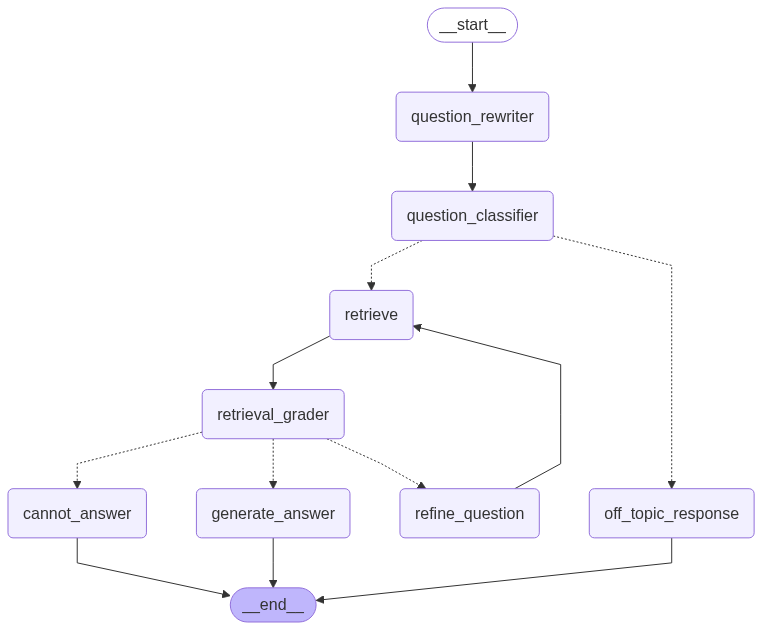

In [12]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Generate a visual representation of the state machine
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [7]:
# # Run the agent on a user-provided question.
# # Each thread_id maintains its own chat history across calls.
# thread_id = 1
# while True:
#     user_q = input("Enter your question (or 'quit' to exit): ").strip()
#     if user_q.lower() == "quit":
#         break
#
#     input_data = {"question": HumanMessage(content=user_q)}
#     result = graph.invoke(input=input_data, config={"configurable": {"thread_id": thread_id}})
#     print("\n--- Agent response ---")
#     # The result dictionary includes the updated state; the last AIMessage is the model's reply
#     if "messages" in result and result["messages"]:
#         latest_reply = [msg for msg in result["messages"] if isinstance(msg, AIMessage)][-1]
#         print(latest_reply.content)
#     else:
#         print("No response.")
#     print("----------------------\n")


In [8]:
# 1. Off-topic question (should trigger the off_topic_response)
input_data = {
    "question": HumanMessage(
        content="How is the weather today?"
    )
}
result = graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})
print(result)

Entering question_rewriter with following state: {'question': HumanMessage(content='How is the weather today?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
Entering on_topic_router
Entering off_topic_response
{'messages': [HumanMessage(content='How is the weather today?', additional_kwargs={}, response_metadata={}), AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': 'No', 'rephrased_question': 'How is the weather today?', 'proceed_to_generate': False, 'rephrase_count': 0, 'question': HumanMessage(content='How is the weather today?', additional_kwargs={}, response_metadata={})}


In [9]:
# 2. On-topic but no relevant documents (refine twice, then cannot_answer)
input_data = {
    "question": HumanMessage(
        content="What is the height of rice plants grown on Mars?"
    )
}
result = graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})
print(result)


Entering question_rewriter with following state: {'question': HumanMessage(content='What is the height of rice plants grown on Mars?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
Entering on_topic_router
Entering off_topic_response
{'messages': [HumanMessage(content='What is the height of rice plants grown on Mars?', additional_kwargs={}, response_metadata={}), AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': 'No', 'rephrased_question': 'What is the height of rice plants grown on Mars?', 'proceed_to_generate': False, 'rephrase_count': 0, 'question': HumanMessage(content='What is the height of rice plants grown on Mars?', additional_kwargs={}, response_metadata={})}


In [10]:
# 3. On-topic with relevant documents (should generate a detailed answer)
input_data = {
    "question": HumanMessage(
        content="What are the key factors affecting organic fertilizer adoption in rice production?"
    )
}
result = graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
print(result)

Entering question_rewriter with following state: {'question': HumanMessage(content='What are the key factors affecting organic fertilizer adoption in rice production?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
Entering on_topic_router
Entering retrieve


C:\Users\shant\AppData\Local\Temp\ipykernel_4468\2809056928.py:12: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = qdrant.search(


retrieve: Retrieved 5 documents
Entering retrieval_grader
Grading document: fecting organic fertilizer ado... Result: Yes
Grading document: ** (54.6) (62.1) Potassium (K2... Result: Yes
Grading document: See discussions, stats, and au... Result: Yes
Grading document: iva- tion, husbandry, agricult... Result: Yes
Grading document: 8 67.7 Female 804 34.0 520 32.... Result: Yes
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Entering generate_answer
generate_answer: Generated response: The adoption of organic fertilizers in rice production is influenced by a variety of factors, as highlighted by a study analyzing data from 3,972 rice farmers in Vietnam. Here are the key factors affecting the adoption of organic fertilizers:

### Positive Influencing Factors

1. **Education**: 
   - Farmers with higher levels of education are more likely to adopt organic fertilizers. This is likely due to better understanding of the benefits and application methods of organic fertilize

In [11]:
# 4. On-topic but may need a refinement to find documents
input_data = {
    "question": HumanMessage(
        content="What are efficient water management techniques for rice farming?"
    )
}
result = graph.invoke(input=input_data, config={"configurable": {"thread_id": 4}})
print(result)

Entering question_rewriter with following state: {'question': HumanMessage(content='What are efficient water management techniques for rice farming?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
Entering on_topic_router
Entering retrieve


C:\Users\shant\AppData\Local\Temp\ipykernel_4468\2809056928.py:12: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  results = qdrant.search(


retrieve: Retrieved 5 documents
Entering retrieval_grader
Grading document: Water management - IRRI Rice K... Result: Yes
Grading document: er for land preparation, perco... Result: Yes
Grading document: if moisture is inadequate for ... Result: Yes
Grading document: necessary if the soil was crac... Result: Yes
Grading document: wherein fields are flooded jus... Result: Yes
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Entering generate_answer
generate_answer: Generated response: Efficient water management is crucial for rice farming, particularly given rice's high water requirements and the increasing scarcity of water resources globally. Here are several key techniques and practices that can enhance water efficiency in rice cultivation:

### 1. **Field Channel Construction**
   - **Purpose**: Constructing field channels allows farmers to control the flow of water to and from their fields more effectively.
   - **Benefits**: This practice enables individual far